In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [37]:
# Standard python libraries
import os
import requests

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco, ReportDecoUtilized
from lightautoml.addons.tabular_interpretation import SSWARM

from imblearn.over_sampling import SMOTE

In [9]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 1000
TARGET_NAME = 'TARGET'
CHUNKSIZE = 100000

In [4]:
DATASET_DIR = '../data/'
DATASET_NAME = 'scoring_data.csv'
DATASET_FULLNAME = os.path.join(DATASET_DIR, DATASET_NAME)

In [5]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [6]:
processed_chunks = []

for chunk in pd.read_csv(DATASET_DIR + DATASET_NAME, sep=';', chunksize=CHUNKSIZE):
    chunk['Инцидентность'] = chunk['Инцидентность'].str.replace(',','.').astype(float)
    processed_chunks.append(chunk)

data = pd.concat(processed_chunks)
data.head()

,Ключ накладной,Вид услуги накладной,Сумма,Город отправитель,Регион отправитель,Город получатель,Регион получатель,Вес нетто,Объем нетто,Количество мест,...,ГМ категория 4,ГМ категория 9,ГМ категория 5,ГМ категория 7,ГМ категория 11,ГМ категория 10,ГМ категория 0,ГМ категория 8,ГМ категория 2,Инцидентность
0,247927160,Авто,1889.0,Новосибирск,Регион 9,Екатеринбург,Регион 7,28.0,0.15,4,...,0,0,0,0,0,0,0,0,0,2.334938
1,249154933,Авто,1115.0,Москва,Регион 3,Вологда,Регион 2,1.0,0.10,1,...,0,0,0,0,0,0,0,0,0,4.672581
2,248192125,Авто,3785.0,Москва,Регион 3,Ливны,Регион 4,42.0,0.24,1,...,0,0,0,0,0,0,0,0,0,2.933025
3,247582270,Авто,2644.0,Энгельс,Регион 5,Апатиты,Регион 2,76.0,0.10,1,...,0,0,0,0,0,0,0,0,0,3.153479
4,248021706,Авто,12702.0,Чита,Регион 12,Рубцовск,Регион 9,40.0,0.86,1,...,0,0,0,0,0,0,0,0,0,3.423653


In [7]:
del(processed_chunks)

In [38]:
data.shape

(6030657, 52)

In [39]:
data.columns

Index(['Ключ накладной', 'Вид услуги накладной', 'Сумма', 'Город отправитель',
       'Регион отправитель', 'Город получатель', 'Регион получатель',
       'Вес нетто', 'Объем нетто', 'Количество мест', 'Ширина', 'Длина',
       'Высота', 'Характер груза', 'ОПФ отправителя', 'Сегмент отправителя',
       'Роль отправителя', 'TARGET', 'АД забор', 'АД отвоз', 'Упаковка',
       'Упаковка амортизирующая', 'Упаковка жесткая',
       'Упаковка воздушно-пузырьковая пленка', 'Картонная коробка',
       'Жесткий короб', 'Упаковка дополнительная', 'Упаковка палетный борт',
       'Упаковка мешок', 'Спец. упаковка для автозапчастей',
       'Комплексная упаковка амортизационная и палетный борт',
       'Комплексная упаковка амортизационная и жесткая упаковка',
       'Спец. упаковка для автостекол', 'Упаковка мягкая', 'Сегмент по ГМ',
       'ГМ паллета', 'ГМ посылка', 'ГМ смешанный сегмент', 'ГМ неформат',
       'ГМ категория 6', 'ГМ категория 3', 'ГМ категория 1', 'ГМ категория 4',
       'ГМ

In [8]:
data.rename(columns={'Наличие оплаченной претензии': 'TARGET'}, inplace=True)

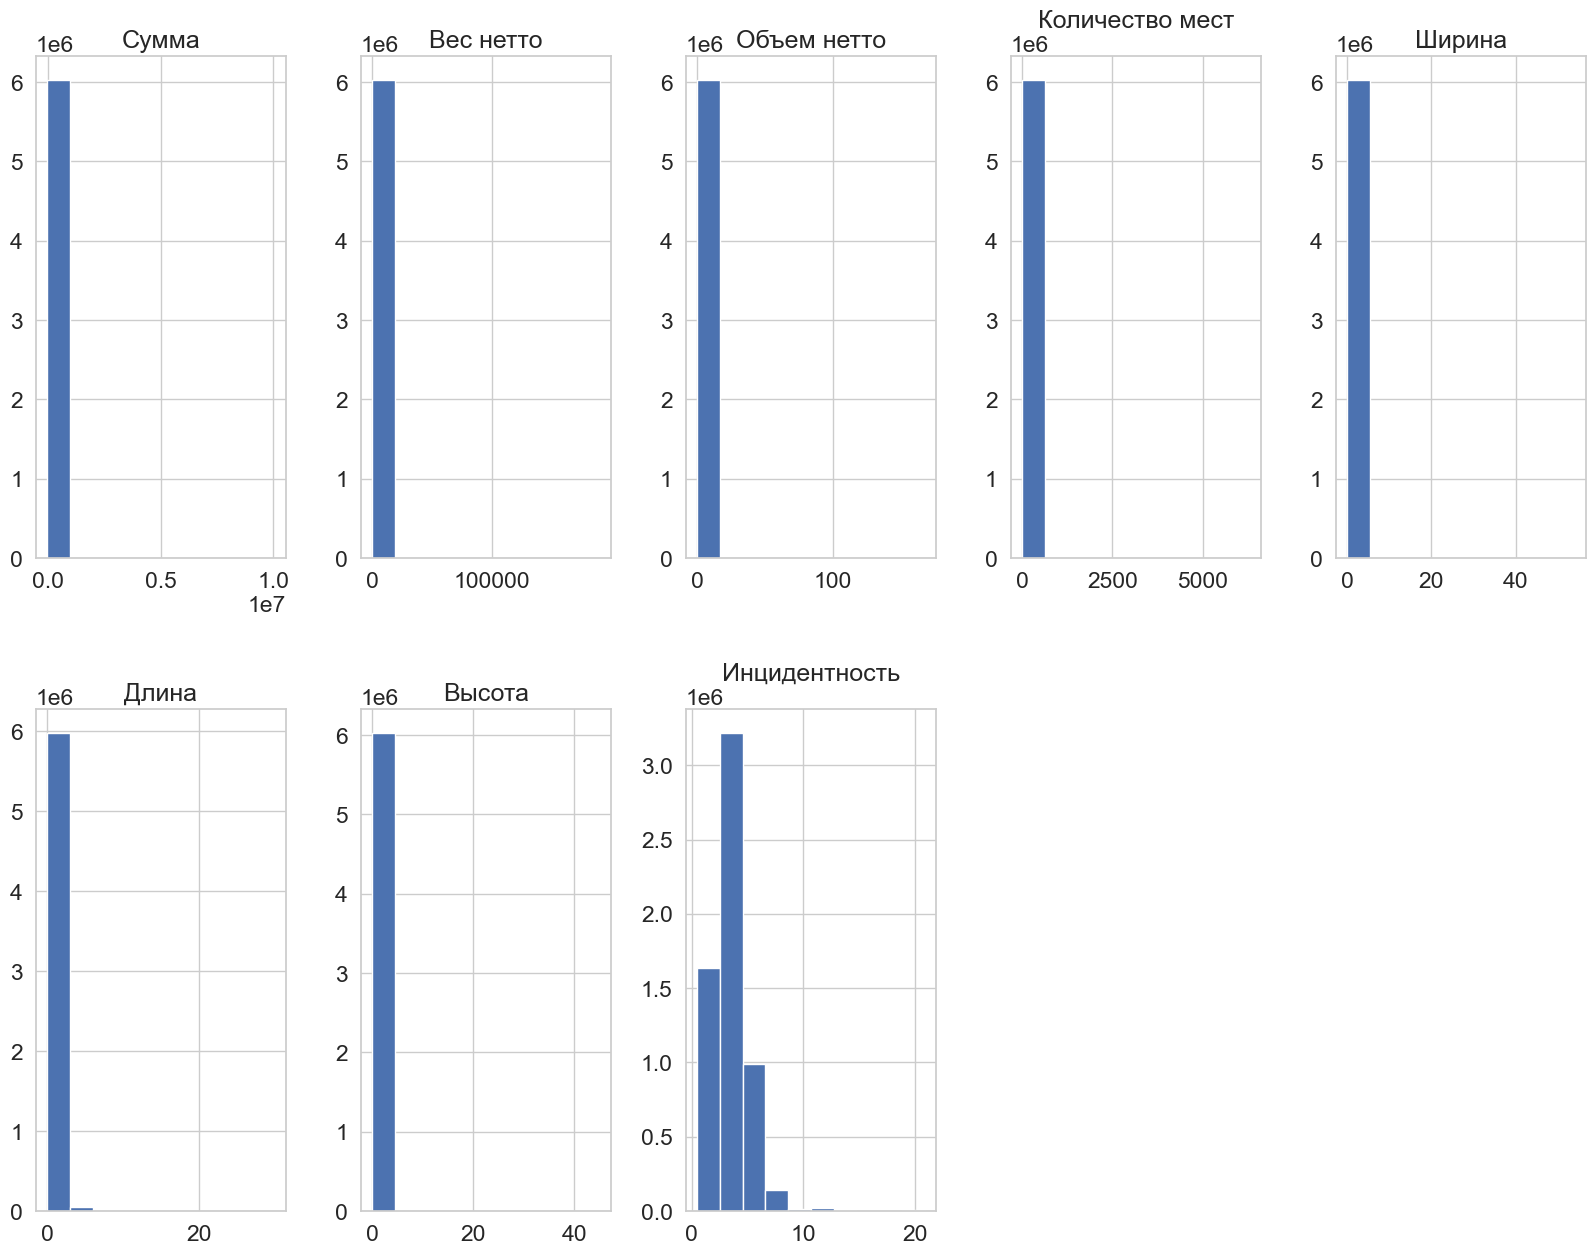

In [36]:
data[['Сумма', 'Вес нетто', 'Объем нетто', 'Количество мест',
                'Ширина', 'Длина', 'Высота', 'Инцидентность']].hist(figsize=(20,15), layout=(-1,5)); 

In [41]:
corr = data.corr(numeric_only=True).round(2)
corr.style.background_gradient(cmap='RdYlGn')

C:\Users\ngirman\AppData\Local\Programs\Python\Python311\Lib\pandas\io\formats\style.py:3931: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
C:\Users\ngirman\AppData\Local\Programs\Python\Python311\Lib\pandas\io\formats\style.py:3932: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,Ключ накладной,Сумма,Вес нетто,Объем нетто,Количество мест,Ширина,Длина,Высота,TARGET,АД забор,АД отвоз,Упаковка,Упаковка амортизирующая,Упаковка жесткая,Упаковка воздушно-пузырьковая пленка,Картонная коробка,Жесткий короб,Упаковка дополнительная,Упаковка палетный борт,Упаковка мешок,Спец. упаковка для автозапчастей,Комплексная упаковка амортизационная и палетный борт,Комплексная упаковка амортизационная и жесткая упаковка,Спец. упаковка для автостекол,Упаковка мягкая,ГМ паллета,ГМ посылка,ГМ смешанный сегмент,ГМ неформат,ГМ категория 6,ГМ категория 3,ГМ категория 1,ГМ категория 4,ГМ категория 9,ГМ категория 5,ГМ категория 7,ГМ категория 11,ГМ категория 10,ГМ категория 0,ГМ категория 8,ГМ категория 2,Инцидентность
Ключ накладной,1.000000,-0.020000,-0.010000,-0.010000,-0.000000,-0.010000,-0.010000,-0.010000,-0.030000,-0.000000,-0.020000,-0.000000,-0.010000,-0.010000,0.000000,0.000000,-0.000000,0.000000,0.010000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,nan,-0.000000,0.020000,0.000000,-0.010000,nan,nan,-0.000000,nan,nan,nan,nan,nan,nan,nan,nan,-0.010000,-0.070000
Сумма,-0.020000,1.000000,0.680000,0.680000,0.280000,0.270000,0.210000,0.310000,0.040000,0.100000,0.100000,0.160000,0.030000,0.170000,0.010000,-0.020000,0.010000,0.100000,0.040000,-0.010000,0.000000,0.010000,0.050000,0.000000,nan,0.160000,-0.190000,0.110000,0.210000,nan,nan,0.010000,nan,nan,nan,nan,nan,nan,nan,nan,-0.000000,0.100000
Вес нетто,-0.010000,0.680000,1.000000,0.710000,0.330000,0.260000,0.190000,0.310000,0.030000,0.070000,0.050000,0.110000,0.020000,0.090000,-0.010000,-0.020000,0.000000,0.130000,0.000000,-0.010000,-0.000000,-0.010000,0.010000,-0.000000,nan,0.190000,-0.220000,0.120000,0.200000,nan,nan,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,-0.000000,0.030000
Объем нетто,-0.010000,0.680000,0.710000,1.000000,0.420000,0.280000,0.190000,0.370000,0.040000,0.080000,0.080000,0.110000,0.030000,0.110000,-0.000000,-0.020000,0.000000,0.110000,-0.000000,-0.010000,0.000000,-0.010000,0.020000,-0.000000,nan,0.190000,-0.210000,0.150000,0.200000,nan,nan,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,-0.000000,0.050000
Количество мест,-0.000000,0.280000,0.330000,0.420000,1.000000,-0.000000,0.010000,-0.000000,0.030000,0.020000,0.040000,0.140000,0.000000,0.020000,-0.010000,-0.010000,0.000000,0.160000,0.080000,-0.010000,-0.000000,0.010000,-0.000000,-0.000000,nan,0.220000,-0.170000,0.320000,0.010000,nan,nan,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,-0.000000,0.020000
Ширина,-0.010000,0.270000,0.260000,0.280000,-0.000000,1.000000,0.630000,0.740000,0.040000,0.060000,0.070000,0.180000,0.050000,0.230000,0.030000,-0.020000,0.010000,0.070000,0.000000,-0.010000,0.010000,0.000000,0.100000,0.010000,nan,0.070000,-0.250000,-0.050000,0.490000,nan,nan,-0.000000,nan,nan,nan,nan,nan,nan,nan,nan,-0.000000,0.030000
Длина,-0.010000,0.210000,0.190000,0.190000,0.010000,0.630000,1.000000,0.480000,0.050000,0.030000,0.050000,0.210000,0.040000,0.300000,0.040000,-0.030000,0.010000,0.090000,-0.010000,-0.020000,0.020000,-0.000000,0.100000,0.020000,nan,-0.000000,-0.260000,-0.070000,0.700000,nan,nan,-0.000000,nan,nan,nan,nan,nan,nan,nan,nan,-0.000000,0.030000
Высота,-0.010000,0.310000,0.310000,0.370000,-0.000000,0.740000,0.480000,1.000000,0.030000,0.070000,0.070000,0.120000,0.050000,0.170000,0.010000,-0.020000,0.000000,0.050000,0.000000,-0.010000,0.010000,-0.000000,0.060000,0.000000,nan,0.110000,-0.210000,-0.040000,0.330000,nan,nan,-0.000000,nan,nan,nan,nan,nan,nan,nan,nan,-0.000000,0.030000
TARGET,-0.030000,0.040000,0.030000,0.040000,0.030000,0.040000,0.050000,0.030000,1.000000,0.010000,0.010000,0.030000,0.010000,0.030000,0.010000,-0.000000,0.000000,0.010000,0.000000,-0.000000,0.000000,0.010000,0.030000,0.000000,nan,0.020000,-0.030000,0.010000,0.050000,nan,nan,-0.000000,nan,nan,nan,nan,nan,nan,nan,nan,0.010000,0.020000
АД забор,-0.000000,0.100000,0.070000,0.080000,0.020000,0.060000,0.030000,0.070000,0.010000,1.000000,0.130000,0.060000,0.010000,0.020000,0.030000,0.020000,0.010000,0.070000,-0.000000,-0.020000,0

In [43]:
data.isna().sum()

Ключ накладной                                                0
Вид услуги накладной                                          0
Сумма                                                         0
Город отправитель                                             0
Регион отправитель                                            0
Город получатель                                              0
Регион получатель                                             0
Вес нетто                                                     0
Объем нетто                                                   0
Количество мест                                               0
Ширина                                                        0
Длина                                                         0
Высота                                                        0
Характер груза                                                0
ОПФ отправителя                                               0
Сегмент отправителя                     

In [44]:
data.fillna(0, inplace=True)

In [46]:
data_wo_text = data[[TARGET_NAME,'Ключ накладной', 
        'Сумма', 'Вес нетто', 'Объем нетто', 'Количество мест',
        'Ширина', 'Длина', 'Высота', 'Инцидентность',
        'АД забор', 'АД отвоз', 'Упаковка',
        'Упаковка амортизирующая', 'Упаковка жесткая',
        'Упаковка воздушно-пузырьковая пленка', 'Картонная коробка',
        'Жесткий короб', 'Упаковка дополнительная', 'Упаковка палетный борт',
        'Упаковка мешок', 'Спец. упаковка для автозапчастей',
        'Комплексная упаковка амортизационная и палетный борт',
        'Комплексная упаковка амортизационная и жесткая упаковка',
        'Спец. упаковка для автостекол', 'Упаковка мягкая',
        'ГМ паллета', 'ГМ посылка', 'ГМ смешанный сегмент', 'ГМ неформат',
        'ГМ категория 6', 'ГМ категория 3', 'ГМ категория 1', 'ГМ категория 4',
        'ГМ категория 9', 'ГМ категория 5', 'ГМ категория 7', 'ГМ категория 11',
        'ГМ категория 10', 'ГМ категория 0', 'ГМ категория 8', 'ГМ категория 2']]

In [48]:
train_data, test_data = train_test_split(
    data_wo_text, 
    test_size=TEST_SIZE, 
    stratify=data[TARGET_NAME], 
    random_state=RANDOM_STATE
)

print(f'Data is splitted. Parts sizes: train_data = {train_data.shape}, test_data = {test_data.shape}')

train_data.head()

Data is splitted. Parts sizes: train_data = (4824525, 42), test_data = (1206132, 42)


,TARGET,Ключ накладной,Сумма,Вес нетто,Объем нетто,Количество мест,Ширина,Длина,Высота,Инцидентность,...,ГМ категория 1,ГМ категория 4,ГМ категория 9,ГМ категория 5,ГМ категория 7,ГМ категория 11,ГМ категория 10,ГМ категория 0,ГМ категория 8,ГМ категория 2
1688707,0,251338043,3554.0,65.0,0.58,6,0.00,0.0,0.00,4.861847,...,0,0,0,0,0,0,0,0,0,0
2418291,0,250678058,2189.0,26.0,0.15,1,0.22,1.0,0.66,5.432791,...,0,0,0,0,0,0,0,0,0,0
324934,0,248586430,3617.0,10.0,0.10,1,0.00,0.0,0.00,2.226036,...,0,0,0,0,0,0,0,0,0,0
3329806,0,250948912,279.0,0.0,0.00,1,0.00,0.0,0.00,4.033813,...,0,0,0,0,0,0,0,0,0,0
2568159,0,249718041,496.0,1.0,0.10,1,0.00,0.0,0.00,2.367733,...,0,0,0,0,0,0,0,0,0,0


In [49]:
smote = SMOTE(random_state=RANDOM_STATE)
train_data_res, test_data_res = smote.fit_resample(train_data, test_data)

ValueError: Unknown label type: continuous-multioutput. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

In [11]:
task = Task('binary')

In [13]:
data.columns

Index(['Ключ накладной', 'Вид услуги накладной', 'Сумма', 'Город отправитель',
       'Регион отправитель', 'Город получатель', 'Регион получатель',
       'Вес нетто', 'Объем нетто', 'Количество мест', 'Ширина', 'Длина',
       'Высота', 'Характер груза', 'ОПФ отправителя', 'Сегмент отправителя',
       'Роль отправителя', 'TARGET', 'АД забор', 'АД отвоз', 'Упаковка',
       'Упаковка амортизирующая', 'Упаковка жесткая',
       'Упаковка воздушно-пузырьковая пленка', 'Картонная коробка',
       'Жесткий короб', 'Упаковка дополнительная', 'Упаковка палетный борт',
       'Упаковка мешок', 'Спец. упаковка для автозапчастей',
       'Комплексная упаковка амортизационная и палетный борт',
       'Комплексная упаковка амортизационная и жесткая упаковка',
       'Спец. упаковка для автостекол', 'Упаковка мягкая', 'Сегмент по ГМ',
       'ГМ паллета', 'ГМ посылка', 'ГМ смешанный сегмент', 'ГМ неформат',
       'ГМ категория 6', 'ГМ категория 3', 'ГМ категория 1', 'ГМ категория 4',
       'ГМ

In [12]:
roles = {
    'target': TARGET_NAME,
    'drop': ['Ключ накладной'],
    'numeric': ['Сумма', 'Вес нетто', 'Объем нетто', 'Количество мест',
                'Ширина', 'Длина', 'Высота', 'Инцидентность'],
    'category': ['АД забор', 'АД отвоз', 'Упаковка',
       'Упаковка амортизирующая', 'Упаковка жесткая',
       'Упаковка воздушно-пузырьковая пленка', 'Картонная коробка',
       'Жесткий короб', 'Упаковка дополнительная', 'Упаковка палетный борт',
       'Упаковка мешок', 'Спец. упаковка для автозапчастей',
       'Комплексная упаковка амортизационная и палетный борт',
       'Комплексная упаковка амортизационная и жесткая упаковка',
       'Спец. упаковка для автостекол', 'Упаковка мягкая',
       'ГМ паллета', 'ГМ посылка', 'ГМ смешанный сегмент', 'ГМ неформат',
       'ГМ категория 6', 'ГМ категория 3', 'ГМ категория 1', 'ГМ категория 4',
       'ГМ категория 9', 'ГМ категория 5', 'ГМ категория 7', 'ГМ категория 11',
       'ГМ категория 10', 'ГМ категория 0', 'ГМ категория 8', 'ГМ категория 2'],
    'text': ['Вид услуги накладной', 'Город отправитель',
       'Регион отправитель', 'Город получатель', 'Регион получатель',
       'Характер груза', 'ОПФ отправителя', 'Сегмент отправителя', 'Роль отправителя',
       'Сегмент по ГМ']
}

In [13]:
automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}, 
)

In [ ]:
automl.fit_predict()

In [14]:
%%time 
out_of_fold_predictions = automl.fit_predict(train_data, roles = roles, verbose = 1)

[09:38:34] Stdout logging level is INFO.
[09:38:34] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[09:38:34] Task: binary

[09:38:34] Start automl preset with listed constraints:
[09:38:34] - time: 1000.00 seconds
[09:38:34] - CPU: 4 cores
[09:38:34] - memory: 16 GB

[09:38:34] Train data shape: (4824525, 52)

[09:39:26] Layer 1 train process start. Time left 948.00 secs
[09:42:56] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[09:45:28] Time limit exceeded after calculating fold 0

[09:45:28] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7874611223788532
[09:45:28] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[09:45:28] Time left 585.61 secs



C:\Users\ngirman\AppData\Local\Programs\Python\Python311\Lib\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\ngirman\AppData\Local\Programs\Python\Python311\Lib\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[09:47:12] Selector_LightGBM fitting and predicting completed
[09:49:55] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


C:\Users\ngirman\AppData\Local\Programs\Python\Python311\Lib\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\ngirman\AppData\Local\Programs\Python\Python311\Lib\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[09:51:29] Time limit exceeded after calculating fold 0

[09:51:29] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8473030079550392
[09:51:29] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[09:51:30] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


Training has stopped (degenerate solution on iteration 11, probably too small l2-regularization, try to increase it)
Training has stopped (degenerate solution on iteration 14, probably too small l2-regularization, try to increase it)


[09:51:59] Time limit exceeded after calculating fold 1

[09:52:00] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.7856337602564492
[09:52:00] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[09:52:00] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 1.00 secs


Training has stopped (degenerate solution on iteration 14, probably too small l2-regularization, try to increase it)


[09:52:19] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[09:52:19] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


Training has stopped (degenerate solution on iteration 21, probably too small l2-regularization, try to increase it)
Training has stopped (degenerate solution on iteration 26, probably too small l2-regularization, try to increase it)
Training has stopped (degenerate solution on iteration 22, probably too small l2-regularization, try to increase it)
Training has stopped (degenerate solution on iteration 25, probably too small l2-regularization, try to increase it)


[09:53:42] Time limit exceeded after calculating fold 3

[09:53:44] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.6557113359787752
[09:53:44] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[09:53:44] Time left 90.11 secs

[09:53:44] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.

[09:53:44] Layer 1 training completed.

[09:53:46] Blending: optimization starts with equal weights and score 0.6469174238738218
[09:54:30] Blending: iteration 0: score = 0.7856337602564492, weights = [0. 0. 1. 0.]
[09:55:03] Blending: iteration 1: score = 0.7890681977993647, weights = [0.         0.08449171 0.9155083  0.        ]
[09:55:39] Blending: iteration 2: score = 0.7890682207231007, weights = [0.         0.08449171 0.91550833 0.        ]
[09:56:13] Blending: iteration 3: score = 0.7890682207231008, weights = [0.         0.08449171 0.91550833 0.        ]
[09:56:47] Blending: iteration 4: score = 0.7890682207723991, weights = [0.         0.

In [15]:
%%time

test_predictions = automl.predict(test_data)
print(f'Prediction for test_data:\n{test_predictions}\nShape = {test_predictions.shape}')

Prediction for test_data:
array([[0.04147559],
       [0.03035073],
       [0.06791846],
       ...,
       [0.04182039],
       [0.06896397],
       [0.07989845]], dtype=float32)
Shape = (1206132, 1)
CPU times: total: 22 s
Wall time: 23.7 s


In [23]:
# print(f'OOF score: {roc_auc_score(train_data[TARGET_NAME].values, out_of_fold_predictions.data[:, 0])}')
print(f'HOLDOUT score: {roc_auc_score(test_data[TARGET_NAME].values, test_predictions.data[:, 0])}')

HOLDOUT score: 0.8023286512855505


In [17]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.08449 * (1 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.91551 * (2 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) 


In [24]:
RD = ReportDeco(output_path = 'tabularAutoML_model_report')

automl_rd = RD(
    TabularAutoML(
        task = task, 
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
    )
)

In [25]:
out_of_fold_predictions = automl_rd.fit_predict(train_data, roles = roles, verbose = 1)

[11:45:05] Stdout logging level is INFO.
[11:45:05] Task: binary

[11:45:05] Start automl preset with listed constraints:
[11:45:05] - time: 1000.00 seconds
[11:45:05] - CPU: 4 cores
[11:45:05] - memory: 16 GB

[11:45:05] Train data shape: (4824525, 52)

[11:46:04] Layer 1 train process start. Time left 940.83 secs
[11:50:48] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[11:53:05] Time limit exceeded after calculating fold 0

[11:53:06] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7874611223788532
[11:53:06] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[11:53:06] Time left 518.96 secs



C:\Users\ngirman\AppData\Local\Programs\Python\Python311\Lib\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\ngirman\AppData\Local\Programs\Python\Python311\Lib\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[11:54:43] Selector_LightGBM fitting and predicting completed
[11:57:23] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


C:\Users\ngirman\AppData\Local\Programs\Python\Python311\Lib\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\ngirman\AppData\Local\Programs\Python\Python311\Lib\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[11:58:51] Time limit exceeded after calculating fold 0

[11:58:51] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8473030079550392
[11:58:51] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[11:58:52] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


Training has stopped (degenerate solution on iteration 11, probably too small l2-regularization, try to increase it)
Training has stopped (degenerate solution on iteration 14, probably too small l2-regularization, try to increase it)


[11:59:18] Time limit exceeded after calculating fold 1

[11:59:19] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.7856337602564492
[11:59:19] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[11:59:19] Time left 146.34 secs

[11:59:19] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.

[11:59:19] Layer 1 training completed.

[11:59:20] Blending: optimization starts with equal weights and score 0.7162687410909241
[11:59:39] Blending: iteration 0: score = 0.7890681977993647, weights = [0.         0.08449171 0.9155083 ]
[11:59:59] Blending: iteration 1: score = 0.7890682207231007, weights = [0.         0.08449171 0.91550833]
[12:00:18] Blending: iteration 2: score = 0.7890682207231008, weights = [0.         0.08449171 0.91550833]
[12:00:37] Blending: iteration 3: score = 0.7890682207231008, weights = [0.         0.08449171 0.91550833]
[12:00:37] Blending: no score update. Terminated

[12:00:38] Automl preset training completed in 932.73 secon

In [27]:
%%time

test_predictions = automl_rd.predict(test_data)
print(f'Prediction for test_data:\n{test_predictions}\nShape = {test_predictions.shape}')

Prediction for test_data:
array([[0.04147559],
       [0.03035073],
       [0.06791846],
       ...,
       [0.04182039],
       [0.06896397],
       [0.07989845]], dtype=float32)
Shape = (1206132, 1)
CPU times: total: 30.4 s
Wall time: 35.9 s


In [28]:
print(f'HOLDOUT score: {roc_auc_score(test_data[TARGET_NAME].values, test_predictions.data[:, 0])}')

HOLDOUT score: 0.8023286525474922


CPU times: total: 62.5 ms
Wall time: 97.6 ms


<Axes: xlabel='Feature'>

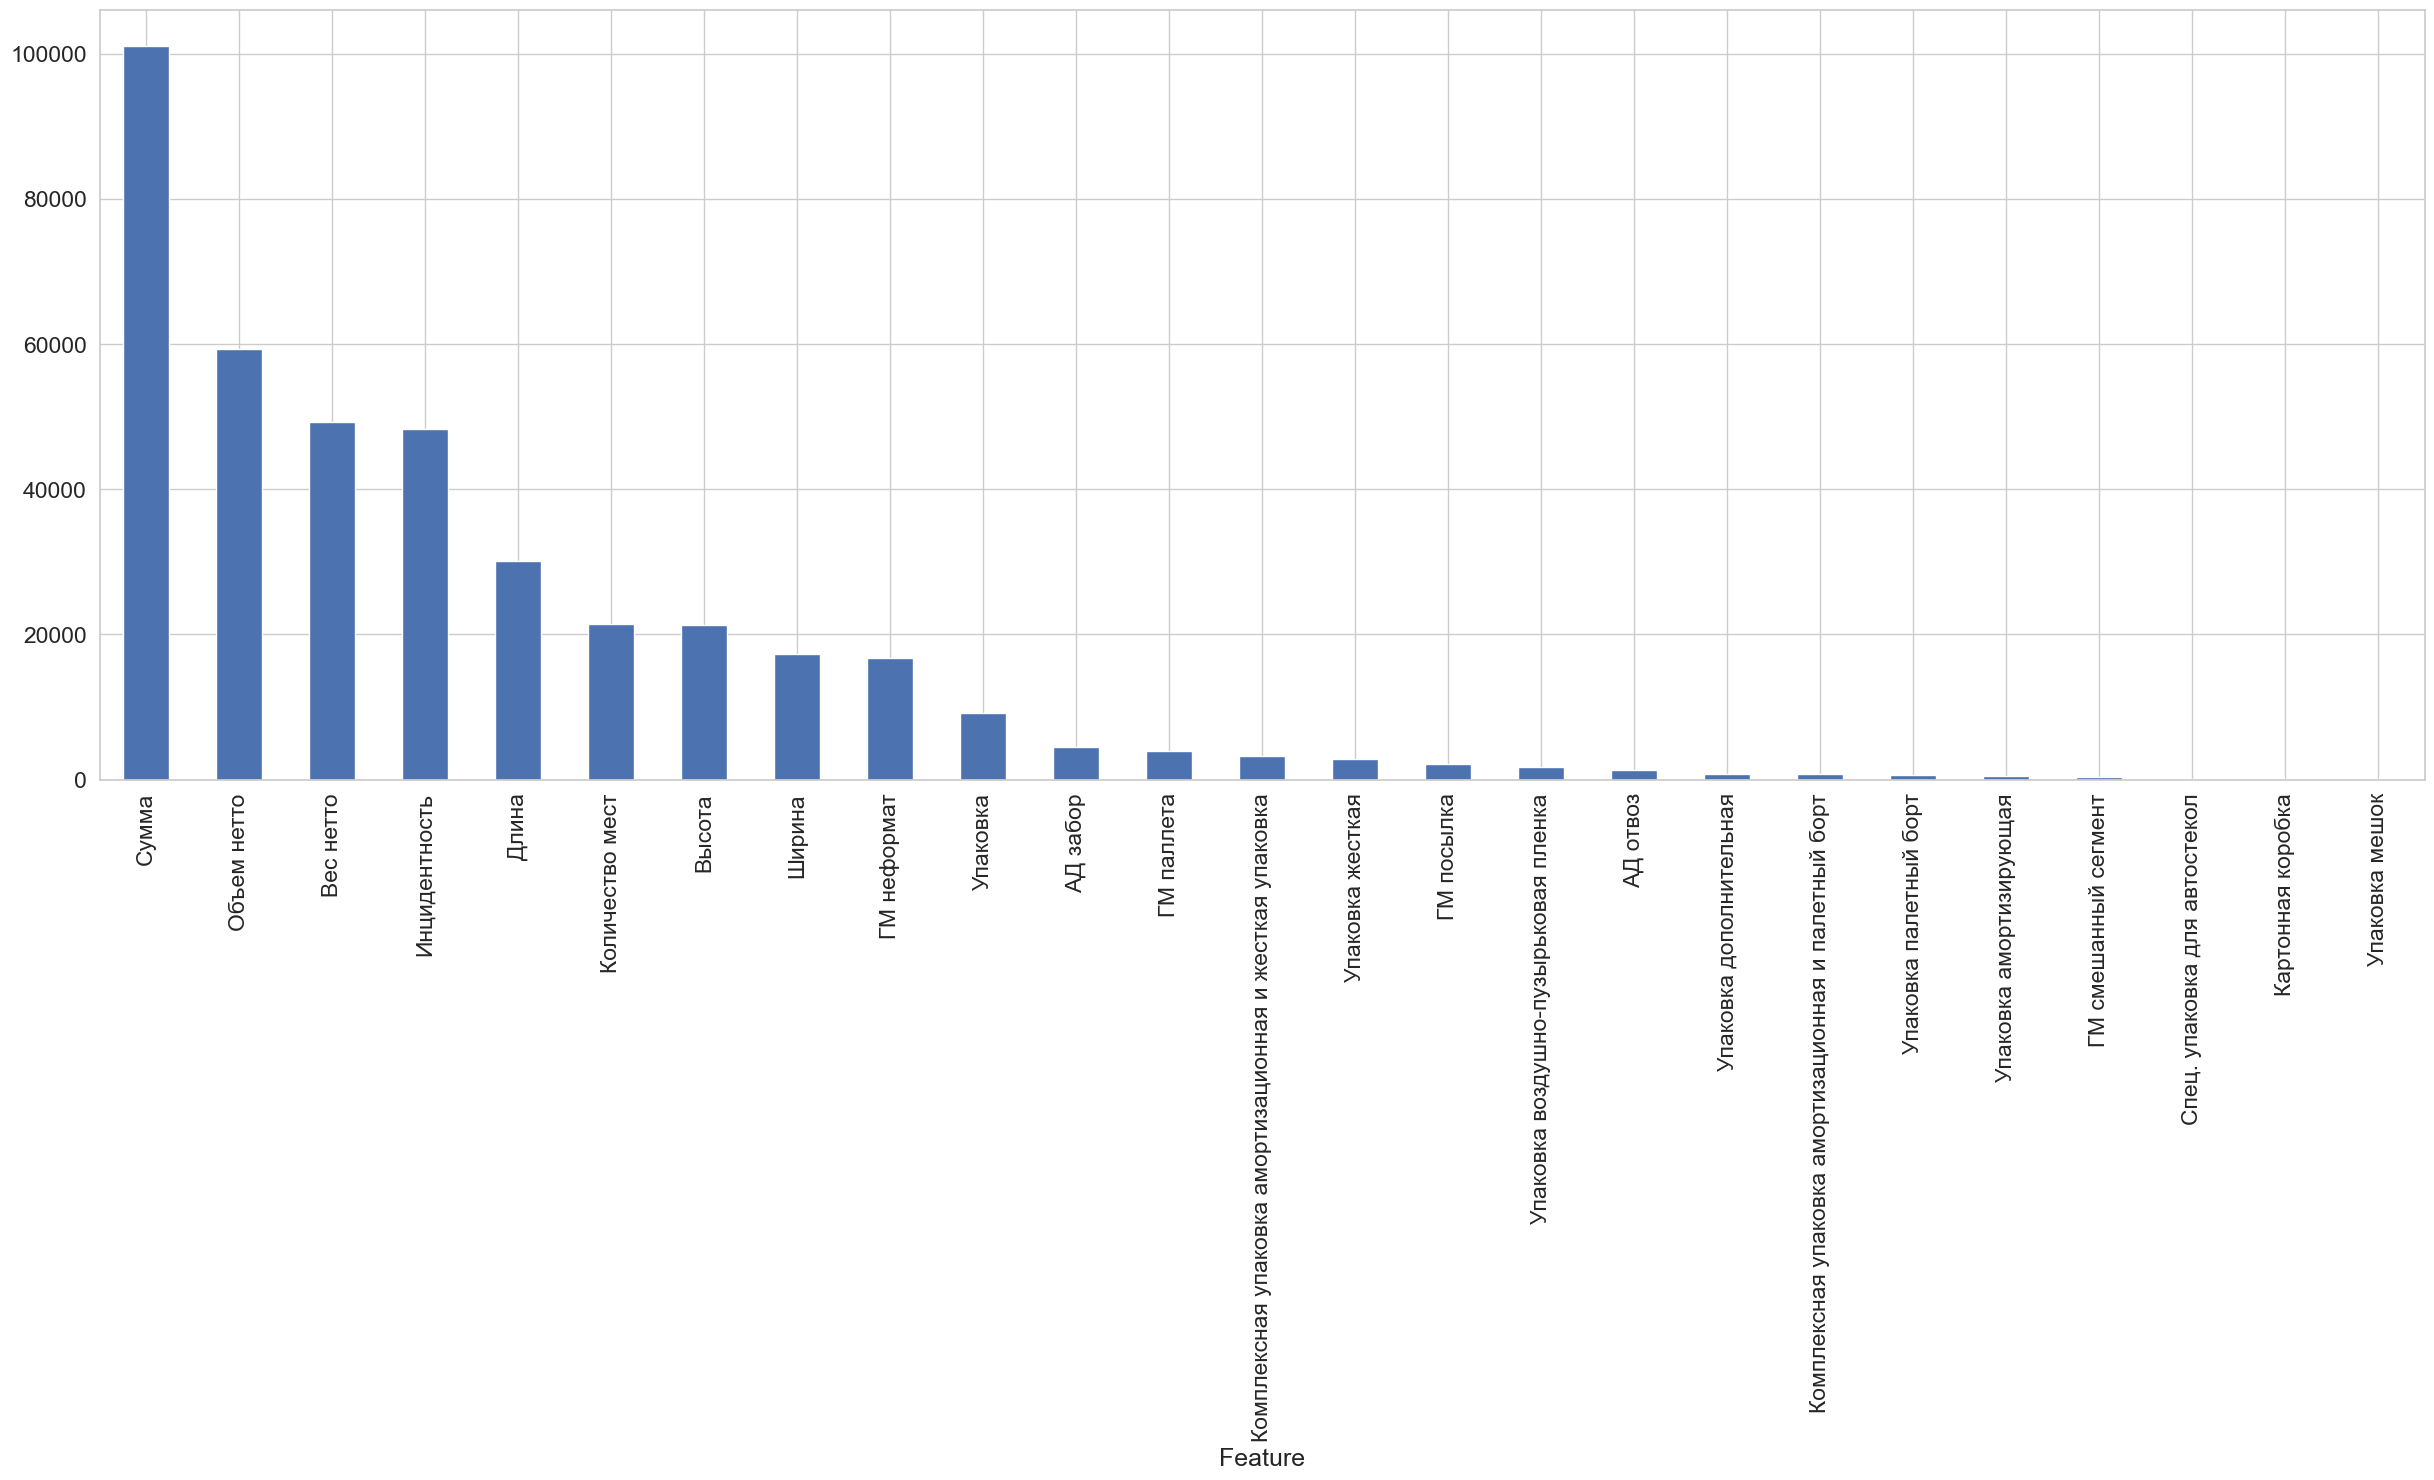

In [29]:
%%time

# Fast feature importances calculation
fast_fi = automl_rd.model.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [30]:
%%time

# Accurate feature importances calculation with detailed info (Permutation importances) -  can take long time to calculate
accurate_fi = automl_rd.model.get_feature_scores('accurate', test_data, silent = True)

CPU times: total: 4min 1s
Wall time: 8min 56s


<Axes: xlabel='Feature'>

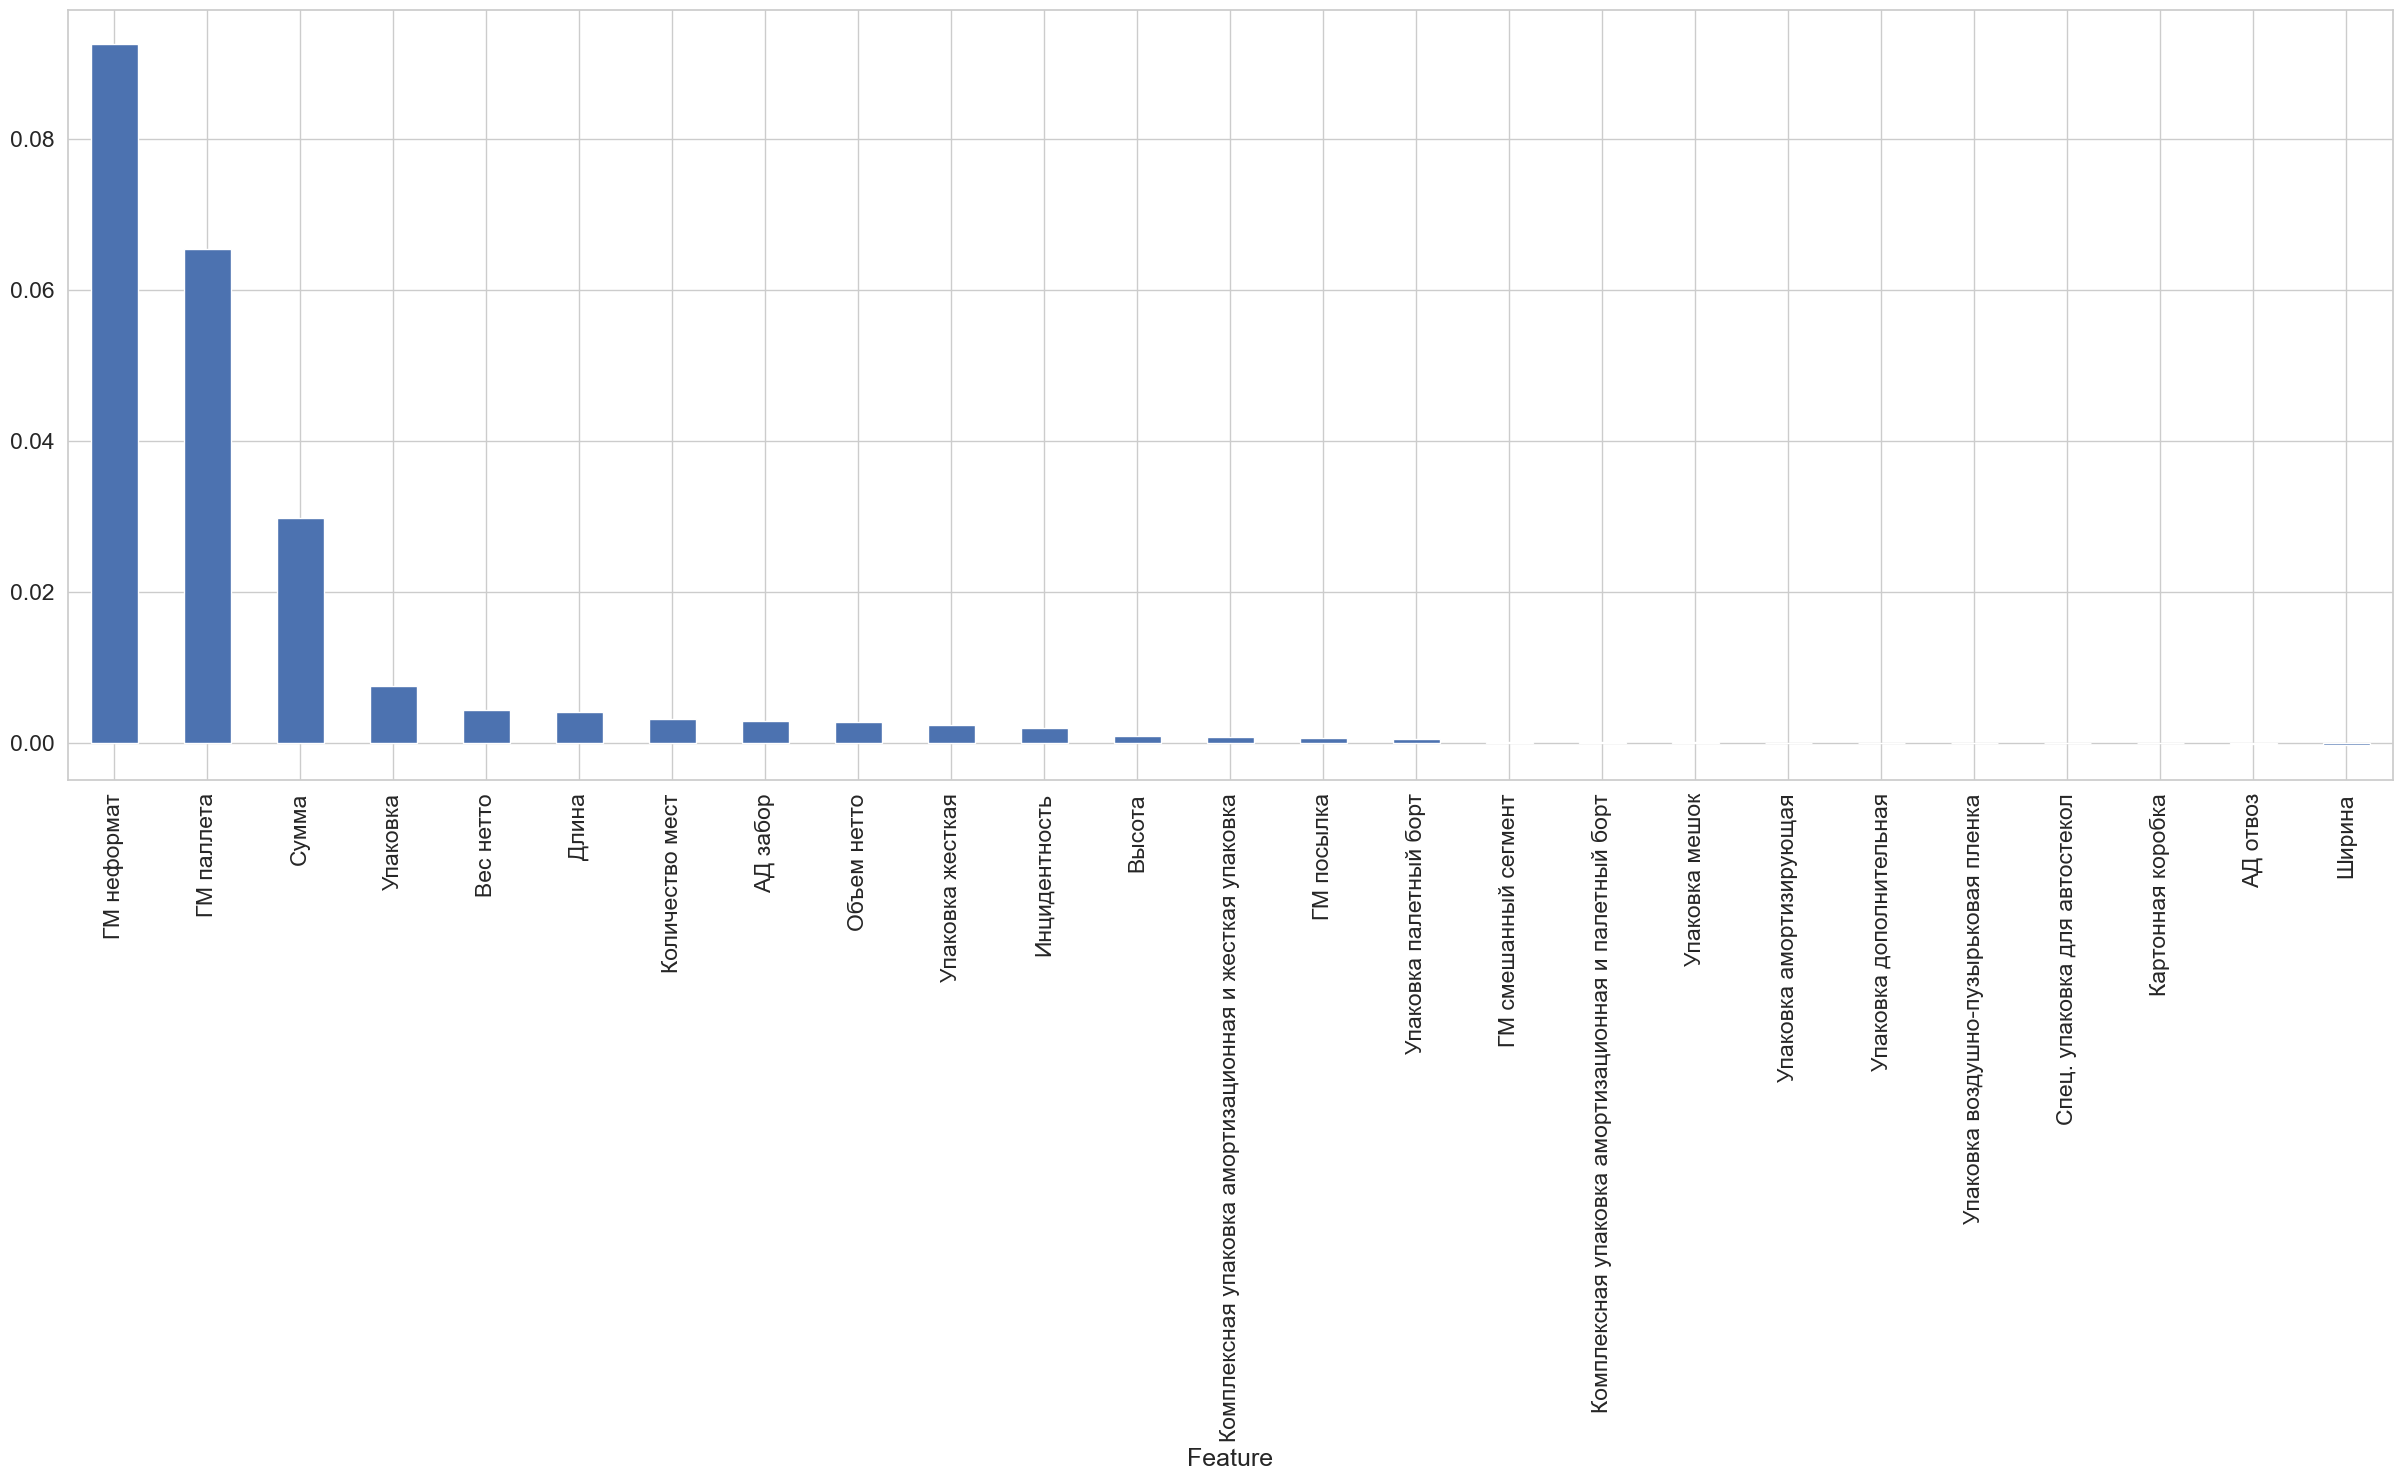

In [31]:
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [34]:
data.TARGET.value_counts()

0    6014188
1      16469
Name: TARGET, dtype: int64

In [33]:
explainer = SSWARM(automl_rd.model)
shap_values = explainer.shap_values(test_data, n_jobs=N_THREADS)

ValueError: Decrease the input number of observations or increase the batch_size